In [1]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('fraud_df.csv')
print(df.shape)
print()
df.head()

(4156, 29)



,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,...,rep_loan_date_day,rep_loan_date_weekday,first_loan_year,first_loan_month,first_loan_day,first_loan_weekday,first_overdue_date_year,first_overdue_date_month,first_overdue_date_day,first_overdue_date_weekday
0,1.0,0.0,0.0,0.0,6,0,0,6,0,0,...,26,2,2015,9,28,1,2016.0,1.0,30.0,2
1,NaN,NaN,NaN,2.0,1,0,0,0,5,0,...,30,3,2015,12,21,1,NaN,NaN,NaN,-1
2,NaN,NaN,NaN,1.0,6,0,0,4,0,0,...,29,6,2015,6,30,5,NaN,NaN,NaN,-1
3,NaN,NaN,NaN,0.0,5,0,3,0,0,0,...,1,5,2015,8,3,1,NaN,NaN,NaN,-1
4,NaN,NaN,NaN,2.0,3,0,0,6,0,0,...,1,2,2015,8,30,3,NaN,NaN,NaN,-1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dpd_5_cnt                   675 non-null    float64
 1   dpd_15_cnt                  675 non-null    float64
 2   dpd_30_cnt                  675 non-null    float64
 3   close_loans_cnt             4141 non-null   float64
 4   federal_district_nm         4156 non-null   int64  
 5   payment_type_0              4156 non-null   int64  
 6   payment_type_1              4156 non-null   int64  
 7   payment_type_2              4156 non-null   int64  
 8   payment_type_3              4156 non-null   int64  
 9   payment_type_4              4156 non-null   int64  
 10  payment_type_5              4156 non-null   int64  
 11  past_billings_cnt           3908 non-null   float64
 12  score_1                     3507 non-null   float64
 13  score_2                     239 n

<Axes: >

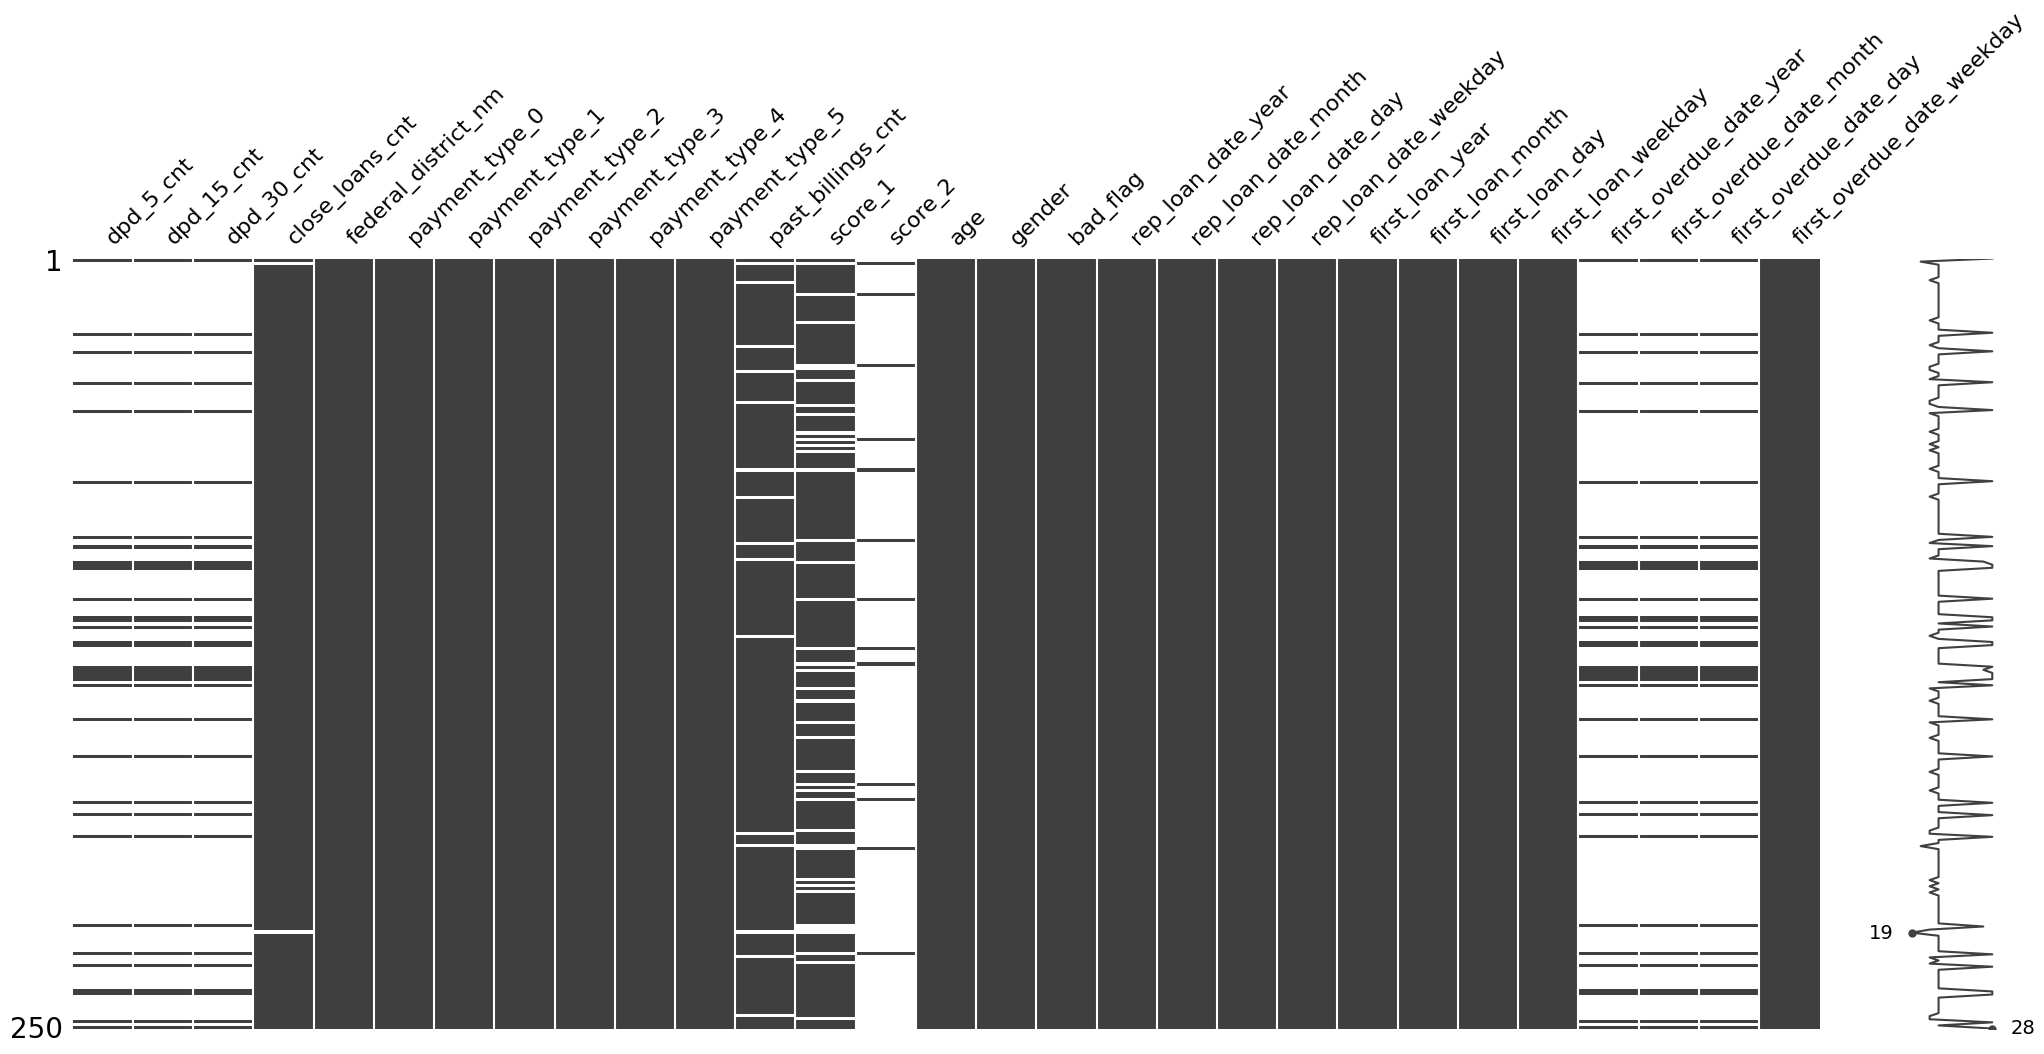

In [4]:
msno.matrix(df.sample(250))

<Axes: >

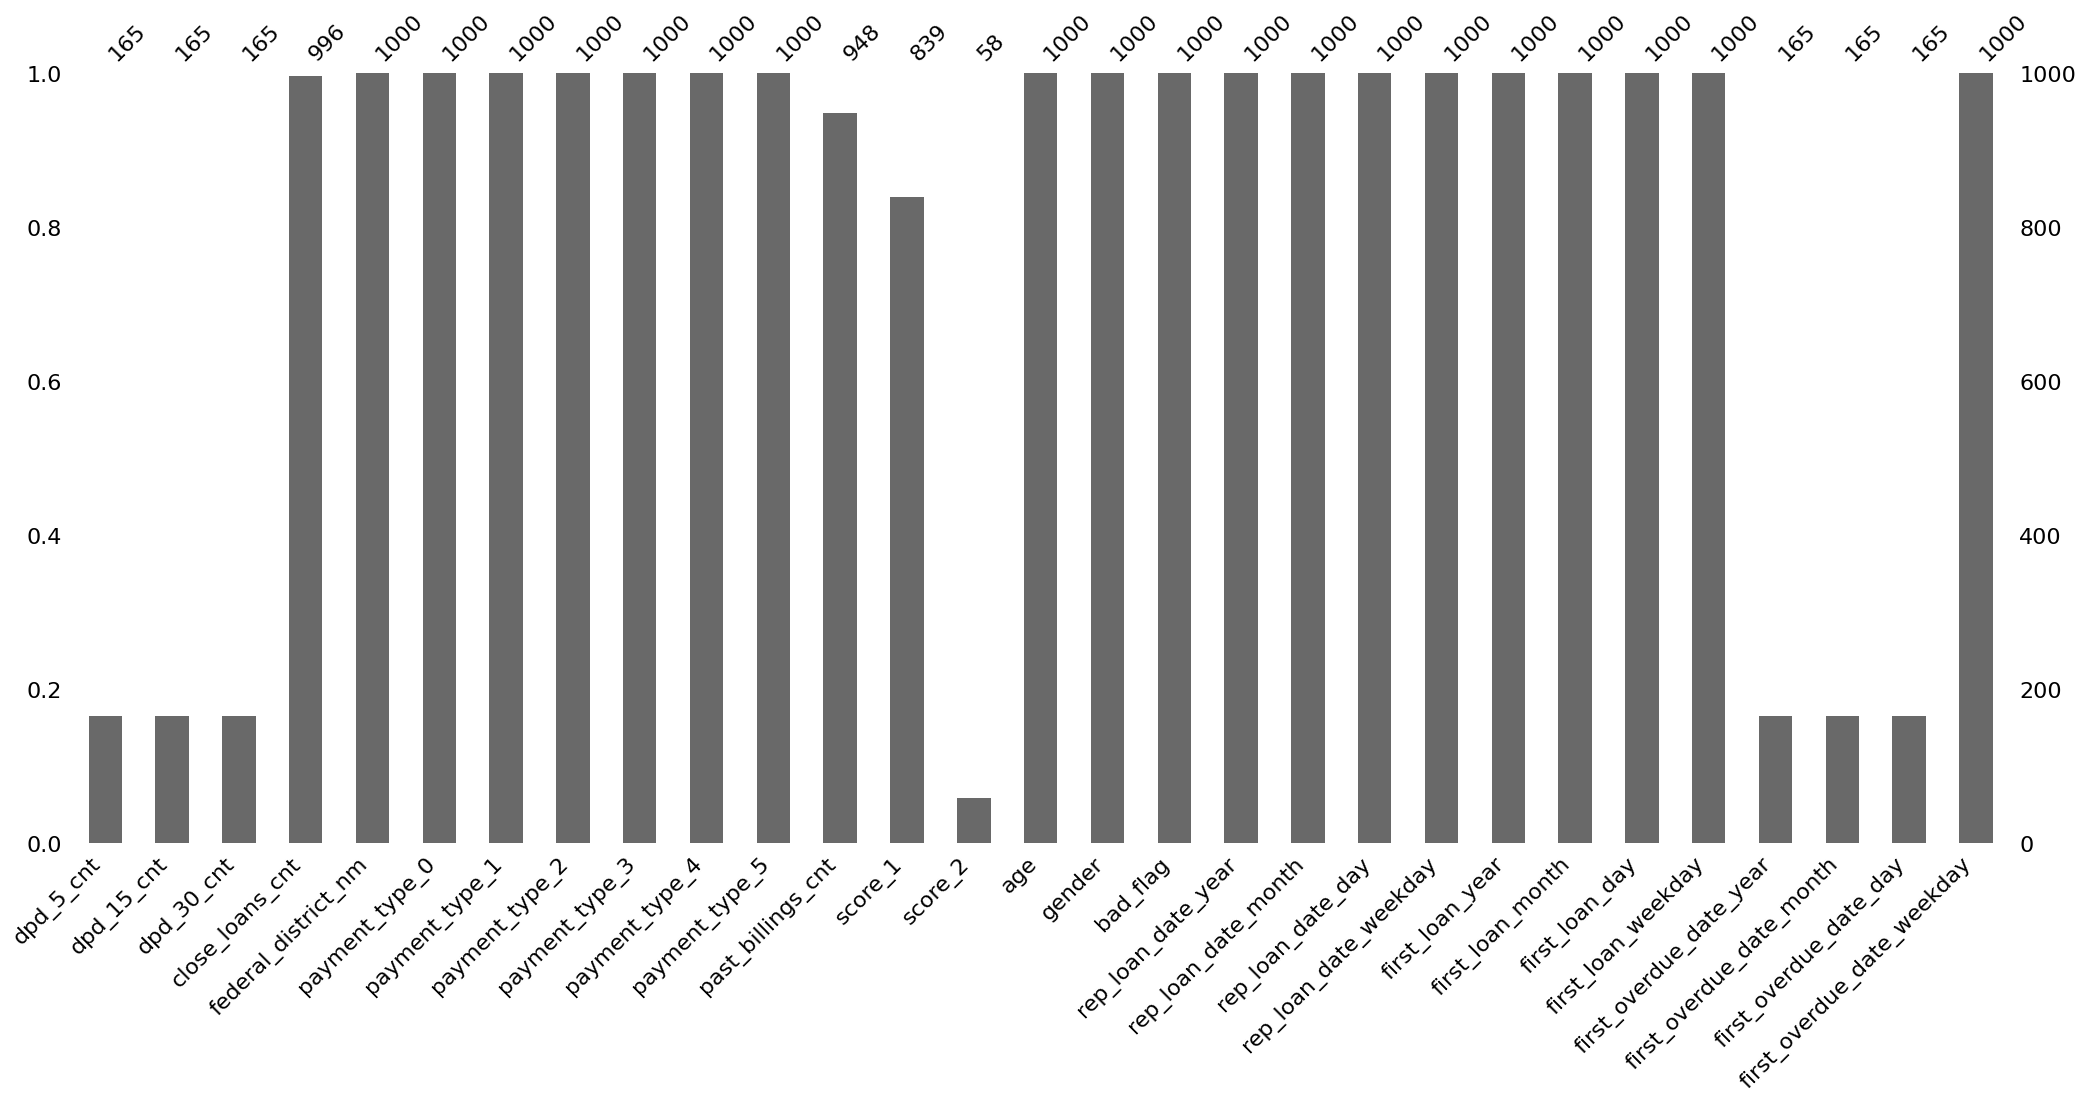

In [5]:
msno.bar(df.sample(1000))

In [6]:
df['dpd_5_cnt'].isna().sum()

np.int64(3481)

In [7]:
# dropping columns vs. dropping rows
# imputing vs. flagging 
# creating 2 separate dataset (main, sparse)
# do target variable values correlate with absence of values in sparse columns?
# select just algos that handle missing data well?

In [8]:
df.bad_flag.unique()

array([0, 1])

In [9]:
df["dpd_5_cnt_missing"] = df["dpd_5_cnt"].isna().astype(int)
df.groupby("dpd_5_cnt_missing")["bad_flag"].mean()


dpd_5_cnt_missing
0    0.195556
1    0.081873
Name: bad_flag, dtype: float64

In [10]:
df.describe()


,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,...,rep_loan_date_weekday,first_loan_year,first_loan_month,first_loan_day,first_loan_weekday,first_overdue_date_year,first_overdue_date_month,first_overdue_date_day,first_overdue_date_weekday,dpd_5_cnt_missing
count,675.000000,675.000000,675.000000,4141.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,...,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,675.000000,675.000000,675.000000,4156.000000,4156.000000
mean,1.444444,0.733333,0.280000,1.184255,3.251925,0.018527,0.596246,3.754331,0.758422,0.019490,...,2.917709,2015.383782,6.671319,16.283927,3.001444,2015.645926,5.825185,16.442963,-0.588787,0.837584
std,0.900599,0.764572,0.502339,1.723692,1.727476,0.330399,2.565179,3.809930,2.212722,0.245989,...,1.913902,0.486364,3.369897,8.721924,1.977125,0.478586,3.444208,9.349825,1.126450,0.368876
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2015.000000,1.000000,1.000000,0.000000,2015.000000,1.000000,1.000000,-1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,2015.000000,4.000000,9.000000,1.000000,2015.000000,3.000000,9.000000,-1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,...,3.000000,2015.000000,6.000000,16.000000,3.000000,2016.000000,6.000000,15.000000,-1.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,4.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,4.250000,2016.000000,10.000000,24.000000,5.000000,2016.000000,8.000000,22.000000,-1.000000,1.000000
max,7.000000,5.000000,3.000000,31.000000,7.000000,15.000000,81.000000,33.000000,35.000000,7.000000,...,6.000000,2016.000000,12.000000,31.000000,6.000000,2016.000000,12.000000,31.000000,6.000000,1.000000
